In [29]:
from __future__ import division
import pandas as pd
import numpy as np
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import pylab as pl
import matplotlib.pyplot as plt
from scipy import optimize
import time

%matplotlib inline

In [41]:
#df = pd.read_csv("../cs-training.csv")
#features  =  ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'age', 'NumberOfTimes90DaysLate']
#X=df[features]
#Y=df.SeriousDlqin2yrs

from sklearn.datasets import make_classification
X, Y = make_classification(n_samples= 10000, n_features=50, n_redundant=10, n_informative=10,
                           random_state=1, n_clusters_per_class=3, n_repeated = 10)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [42]:
# Random Logits
num_logits = 100
num_features = 10
clf = BaggingClassifier(base_estimator = LogisticRegression(),n_estimators=num_logits, max_features = num_features)
clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=10,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [43]:
# print feature importances and feature indices

for logit in clf.estimators_:
    print (logit.coef_)
    
for logit in clf.estimators_features_:
    print (logit)

[[ 0.04278096 -0.00578652 -0.01017553 -0.02281742 -0.20245823  0.16022224
  -0.60743226 -0.01291772  0.09587972  0.02940175]]
[[ 0.19867037  0.00365484  0.11324191  0.01428902 -0.75069472  0.15925832
  -0.31049588 -0.02868333 -0.05278228  0.0088661 ]]
[[ 0.41735341 -0.01232889  0.18943078  0.02075197 -0.51375111  0.01725254
  -0.05904185  0.01400404 -0.04423286  0.13351217]]
[[-0.00681096  0.02471828 -0.02891005  0.04197511  0.00467625  0.01470153
  -0.16071556  0.02632712  0.04197511 -0.17619635]]
[[-0.05491683 -0.21087401  0.04566719  0.05007382  0.04864151  0.04058058
  -0.05345434 -0.05491683 -0.02261277 -0.11107564]]
[[-0.23692376 -0.00765901 -0.02555747  0.05110785  0.10057303 -0.06065608
   0.32305135  0.36770106 -0.06110821  0.02367812]]
[[ -3.72472288e-02  -1.45730507e-01   6.25315527e-05  -7.58405466e-02
   -4.80621001e-01  -8.17792487e-02   3.17325032e-01  -1.59055807e-01
    6.02149524e-02  -8.05124560e-02]]
[[ 0.00296056 -0.02394753 -0.02926485 -0.02062963  0.00296056 -0.0

In [44]:
total_features = X.shape[1]
feature_importance_matrix = np.zeros((num_logits, total_features))
row = 0
for feature in clf.estimators_features_:
    for i in range(num_features):
        feature_importance_matrix[row][feature[i]] = clf.estimators_[row].coef_[0][i] 
    row += 1
feature_importance_matrix[feature_importance_matrix==0]=['nan']
#print feature_importance_matrix
mean_importance_rl = np.nanmean(feature_importance_matrix, dtype=np.float64, axis=0)
std_importance_rl = np.nanstd(feature_importance_matrix, dtype=np.float64,axis=0)

#print "mean is ", np.nanmean(feature_importance_matrix, dtype=np.float64, axis=0)
#print "stdev is ", np.nanstd(feature_importance_matrix, dtype=np.float64,axis=0)


In [ ]:
# let's compare it to RFs

clfrf = RandomForestClassifier(n_estimators= num_logits, max_features = num_features, n_jobs=-1)
clfrf.fit(X_train, y_train)
clfrf.feature_importances_

In [38]:
def plot_feature_importance(mean_importance_array, std_importance_array, indices, label):
    # Print the feature ranking
    print("Ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], mean_importance_array[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title(label)
    plt.bar(range(X.shape[1]), mean_importance_array[indices],
            color="r", yerr=std_importance_array[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

Ranking:
1. feature 135 (nan)
2. feature 111 (-0.113820)
3. feature 170 (-0.105942)
4. feature 65 (0.099548)
5. feature 166 (-0.088074)
6. feature 79 (0.087153)
7. feature 55 (0.077210)
8. feature 26 (0.076878)
9. feature 66 (-0.075701)
10. feature 194 (-0.071124)
11. feature 150 (0.070288)
12. feature 191 (-0.065567)
13. feature 5 (-0.061416)
14. feature 125 (0.061104)
15. feature 13 (-0.060618)
16. feature 81 (0.056330)
17. feature 20 (-0.055617)
18. feature 102 (-0.055451)
19. feature 136 (-0.052112)
20. feature 187 (0.051794)
21. feature 124 (-0.046402)
22. feature 7 (-0.044300)
23. feature 89 (0.043052)
24. feature 44 (0.042997)
25. feature 158 (-0.042333)
26. feature 94 (0.042257)
27. feature 8 (-0.040721)
28. feature 154 (-0.040294)
29. feature 182 (-0.039640)
30. feature 15 (0.039271)
31. feature 30 (-0.038003)
32. feature 70 (-0.037821)
33. feature 48 (0.036736)
34. feature 84 (-0.036566)
35. feature 99 (-0.036279)
36. feature 25 (-0.035416)
37. feature 131 (-0.035380)
38. fea

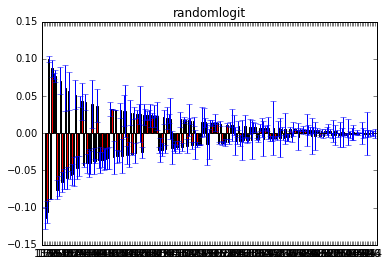

Ranking:
1. feature 141 (0.018901)
2. feature 111 (0.015247)
3. feature 65 (0.014772)
4. feature 166 (0.014578)
5. feature 170 (0.013356)
6. feature 17 (0.010801)
7. feature 79 (0.010729)
8. feature 120 (0.009817)
9. feature 110 (0.009794)
10. feature 66 (0.009747)
11. feature 36 (0.009493)
12. feature 122 (0.009164)
13. feature 145 (0.009075)
14. feature 173 (0.008799)
15. feature 52 (0.008763)
16. feature 161 (0.008631)
17. feature 115 (0.008387)
18. feature 10 (0.008288)
19. feature 71 (0.008160)
20. feature 53 (0.007987)
21. feature 3 (0.007937)
22. feature 59 (0.007917)
23. feature 55 (0.007613)
24. feature 177 (0.007564)
25. feature 68 (0.007500)
26. feature 85 (0.007145)
27. feature 89 (0.007141)
28. feature 191 (0.007098)
29. feature 155 (0.006993)
30. feature 116 (0.006977)
31. feature 26 (0.006930)
32. feature 135 (0.006873)
33. feature 194 (0.006742)
34. feature 102 (0.006694)
35. feature 146 (0.006621)
36. feature 167 (0.006620)
37. feature 5 (0.006587)
38. feature 12 (0.00

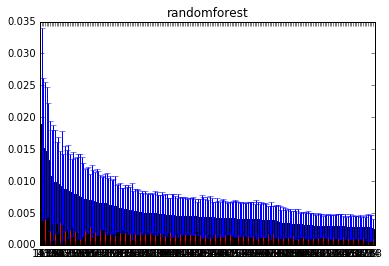

In [39]:
indices_rl = np.argsort(np.abs(mean_importance_rl))[::-1]
# std_important_rl is buggy but will fix it later
plot_feature_importance(mean_importance_rl, std_importance_rl, indices_rl, "randomlogit")

importance_rf = clfrf.feature_importances_
std_importance_rf = np.std([tree.feature_importances_ for tree in clfrf.estimators_],
             axis=0)
indices_rf = np.argsort(importance_rf)[::-1]
plot_feature_importance(importance_rf, std_importance_rf, indices_rf, "randomforest")
